In [1]:
library(R.matlab)
library(ggplot2)
library(fda)
library(caTools)
library(gdpc)
library(repr)
library(MASS)

R.matlab v3.6.1 (2016-10-19) successfully loaded. See ?R.matlab for help.

Attaching package: ‘R.matlab’

The following objects are masked from ‘package:base’:

    getOption, isOpen

Loading required package: splines
Loading required package: Matrix

Attaching package: ‘fda’

The following object is masked from ‘package:graphics’:

    matplot



In [2]:
# Change plot size to 5 x 4
options(repr.plot.width=5, repr.plot.height=4)

In [3]:
# Utility function to get the factors from models
get_factors <- function(model, num_epochs=300) {
    factors_list = list()
    for (epoch in 1:num_epochs) {
        factor = model[, epoch]$f
        factor = (factor - mean(factor)) / sd(factor)
        factors_list[[epoch]] = factor
    }
    res <- do.call(cbind, factors_list)
    return(res)
}

# Utilitiy function to get MSE from models
get_mse <- function(model, num_epochs=300) {
    mse_list = list()
    for (epoch in 1:num_epochs) {
        mse = model[, epoch]$mse
        mse_list[[epoch]] = mse
    }
    return(mse_list)
}

In [4]:
# Collect log periodograms of factors for each epoch
log_periodograms <- function(factors, num_epochs, smooth=TRUE, window=11, tlim=500) {
    
    # Smooth the log periodograms
    smoothing <- function(log_pds, w=window) {
        sm_log_pd_list = list()
        for(i in 1:num_epochs) {
            sm_log_pd = stats::filter(log_pds[[i]], rep(1/w, w), circular=TRUE)
            sm_log_pd_list[[i]] = sm_log_pd
        }
        res <- do.call(cbind, sm_log_pd_list)
        return (res)
    }
    
    logpd.list = c()
    for (i in 1:num_epochs) {
        factor_epoch = factors[, i]
        periodogram = (abs(fft(factor_epoch)))^2
        log_pd = log(periodogram[1:tlim])
        logpd.list[[i]] = log_pd
    }
    if (smooth) {
        res <- smoothing(logpd.list)
    }
    else {
        res <- do.call(cbind, logpd.list)
    }
    return (res)
}

In [5]:
plot_factors <- function(GDPC, SPCA, epoch) {
    ulim = max(max(SPCA[5:995, epoch], GDPC[5:995, epoch]))
    llim = min(min(SPCA[5:995, epoch], GDPC[5:995, epoch]))
    par(mar=c(6.1, .5, 2.1, 6.1), xpd=TRUE)
    plot(GDPC[5:995, epoch], xaxt="n", yaxt="n", type='l', ylab='',ylim=c(llim, ulim),
         main=sprintf("Epoch %s: First Factors", epoch),xlab='ms', bty="n", col="darkblue")
    lines(SPCA[5:995, epoch], col=2, xpd=FALSE)
    axis(side=1, at=seq(0, 1000, 1000))
    par(xpd=TRUE)
    legend("topright", ex.cs1, cex=0.9, y.intersp=2.5,legend=c("GDPCA", "SPCA"), bty="n", 
           lty=c(1,1),col=c("darkblue", "red"), inset=c(-0.3, 0), text.font=2)
}

plot_periodograms <-function(Xgpd, Xspd, epoch) {
    ulim = max(max(Xspd[7:495, epoch], Xgpd[7:495, epoch]))
    llim = min(min(Xspd[7:495, epoch], Xgpd[7:495, epoch]))
    par(mar=c(6.1, 0.5, 4.1, 4.1), xpd=TRUE)
    plot(Xspd[7:495, epoch], xaxt="n", yaxt="n", type='l', ylab='', xlab='Hz',ylim=c(llim, ulim),
         main=sprintf("Epoch %s: Log Periodograms", epoch), bty='n', col='red')
    lines(Xgpd[7:495, epoch], col="darkblue", xpd=FALSE)
    axis(side=1, at=seq(0, 500, 500))
    legend("topright", ex.cs1, cex=0.9, y.intersp=2.5,legend=c("GDPCA", "SPCA"), bty="n", 
           lty=c(1,1),col=c("darkblue", "red"), inset=c(-.17, 0), text.font=2)
}

In [6]:
# Functions to save factors and log periodograms
save_factor_plots <- function(G, S, epochs, subdir="lagx_factors") {
    pardir =  "."
    if (!dir.exists(file.path(pardir, subdir))) {
        dir.create(file.path(pardir, subdir))
    }

    for (i in epochs) {
        png(filename=sprintf("%s/%s_epoch%s.png", subdir, subdir, i),
            width=5, height=5, units="in", res=600)
        plot_factors(G, S, i)
        dev.off()
    }
}

save_logp_plots <- function(G, S, epochs, subdir="lagx_logp") {
    pardir =  "."
    if (!dir.exists(file.path(pardir, subdir))) {
        dir.create(file.path(pardir, subdir))
    }

    for (i in epochs) {
        png(filename=sprintf("%s/%s_epoch%s.png", subdir, subdir, i),
            width=5, height=5, units="in", res=600)
        plot_periodograms(G, S, i)
        dev.off()
    }
}

In [7]:
plot_lfp_factor <- function(lfp, G, S, epoch) {
    par(mar=c(6.1, 4.1, 4.1, 4.1), xpd=TRUE)
    params = list(yaxt="n", xaxt="n", ylab="", xlab="ms", 
              bty="n", main=sprintf("Epoch %s: LFPs 1-10 Channels", epoch), xpd=FALSE)
    ts.plot(lfp[((epoch-1)*1000+1):(epoch*1000),], gpars=params)
    lines(G[,epoch], col='red', lwd=2)
    lines(S[,epoch], col='orange', lwd=2)
    axis(side=1, at=seq(0, 1000, 1000))
    legend("topright", ex.cs1, cex=0.6, y.intersp=2.5,legend=c("GDPCA", "SPCA"), bty="n", 
           lty=c(1,1),col=c("red", "orange"), inset=c(-0.17, 0))
}

plot_post_lfp_factor <- function(lfp, G, S, epoch, legend, with_gdpc=TRUE, with_spca=TRUE) {
    excludes = c(1:5, 7:8, 11:12, 14:16, 18:26, 28:32)
    epochs_exc_11_15_16 = c(54, 63, 64, 114:117, 136:141, 151:154, 161:168,
                        182:187, 200:208, 223:225, 237:240, 296:297)
    epochs_exc_chs_15_16 = c(62, 65, 66)
    epochs_exc_chs_11_16 = c(236, 241, 243)
    epochs_exc_chs_16 = c(171, 172)
    if(is.element(epoch, epochs_exc_11_15_16)){
        exs = c(1:5, 7:8, 12, 14, 18:26, 28:32)
    }else if(is.element(epoch, epochs_exc_chs_15_16)){
        exs = c(1:5, 7:8, 11:12, 14, 18:26, 28:32)
    }else if(is.element(epoch, epochs_exc_chs_11_16)){
        exs = c(1:5, 7:8, 12, 14:15, 18:26, 28:32)
    }else if(is.element(epoch, epochs_exc_chs_16)){
        exs = c(1:5, 7:8, 11:12, 14:15, 18:26, 28:32)
    } else if(epoch==118){
        exs = c(1:5, 7:8, 12, 14:16, 18:26, 28:32)
    } else {
        exs = excludes
    }

    par(mar=c(6.1, 0.5, 4.1, 6.5), xpd=TRUE)
    start = (epoch-1)*1000+1
    end = epoch*1000
    ulim = max(max(G[5:995, epoch], lfp[(start+5):(end-5), exs]))
    llim = min(min(G[5:995, epoch], lfp[(start+5):(end-5), exs]))
    params = list(yaxt="n", xaxt="n", ylab="", xlab="ms", ylim=c(llim, ulim),
                  bty="n", main=sprintf("Epoch %s: LFPs 1-10 Channels", epoch), xpd=FALSE)
    ts.plot(lfp[(start+5):(end-5), exs], gpars=params)
    if (with_gdpc) {
        lines(G[5:995,epoch], col='red', lwd=2)
    }
    if (with_spca){
        lines(S[5:995,epoch], col='orange', lwd=2)
    }
    axis(side=1, at=seq(0, 1000, 1000))
    legend("topright", ex.cs1, cex=0.6, y.intersp=2.5, legend=legend, bty="n", 
           lty=c(1,1),col=c("red", "orange"), inset=c(-0.3, 0))
}

In [8]:
normalize_post <- function(data, epochs=c(1:300)) {
    Z = data
    excludes = c(1:5, 7:8, 11:12, 14:16, 18:26, 28:32)
    epochs_exc_11_15_16 = c(54, 63, 64, 114:117, 136:141, 151:154, 161:168,
                        182:187, 200:208, 223:225, 237:240, 296:297)
    epochs_exc_chs_15_16 = c(62, 65, 66)
    epochs_exc_chs_11_16 = c(236, 241, 243)
    epochs_exc_chs_16 = c(171, 172)
    for (i in epochs) {
        if(is.element(i, epochs_exc_11_15_16)){
            exs = c(1:5, 7:8, 12, 14, 18:26, 28:32)
        }else if(is.element(i, epochs_exc_chs_15_16)){
            exs = c(1:5, 7:8, 11:12, 14, 18:26, 28:32)
        }else if(is.element(i, epochs_exc_chs_11_16)){
            exs = c(1:5, 7:8, 12, 14:15, 18:26, 28:32)
        }else if(is.element(i, epochs_exc_chs_16)){
            exs = c(1:5, 7:8, 11:12, 14:15, 18:26, 28:32)
        } else if(i==118){
            exs = c(1:5, 7:8, 12, 14:16, 18:26, 28:32)
        } else {
            exs = excludes
        }
        Zepoch = Z[((i-1)*1000+1):(i*1000), exs]
        Z[((i-1)*1000+1):(i*1000), exs] = (Zepoch - mean(Zepoch)) / sd(Zepoch)
    }
    return(Z)
}

In [9]:
# Functions to save factors superimposed with lfp
save_lfp_factors <- function(Z, G, S, epochs, legend, subdir="lagx_lfp_gfactor", gdpc=TRUE, spca=FALSE) {
    pardir =  "."
    if (!dir.exists(file.path(pardir, subdir))) {
        dir.create(file.path(pardir, subdir))
    }

    for (i in epochs) {
        png(filename=sprintf("%s/%s_epoch%s.png", subdir, subdir, i),
            width=5, height=5, units="in", res=600)
        plot_post_lfp_factor(Z, G, S, i, legend=legend, with_gdpc=gdpc, with_spca=spca)
        dev.off()
    }
}

In [10]:
recons_gdpc_epoch <- function(model, epoch) {
    out <- model[, epoch]
    class(out) <- append(class(out), "gdpc")
    recons <- fitted(out, epoch)
    return(recons)
}

plot_post_lfp_recons <- function(Z, G, model, epoch, legend) {
    excludes = c(1:5, 7:8, 11:12, 14:16, 18:26, 28:32)
    epochs_exc_11_15_16 = c(54, 63, 64, 114:117, 136:141, 151:154, 161:168,
                            182:187, 200:208, 223:225, 237:240, 296:297)
    epochs_exc_chs_15_16 = c(62, 65, 66)
    epochs_exc_chs_11_16 = c(236, 241, 243)
    epochs_exc_chs_16 = c(171, 172)
    if (epoch %in% epochs_exc_11_15_16) {
        exs = c(1:5, 7:8, 12, 14, 18:26, 28:32)
    } else if(epoch %in% epochs_exc_chs_15_16) {
        exs = c(1:5, 7:8, 11:12, 14, 18:26, 28:32)
    } else if(epoch %in% epochs_exc_chs_11_16) {
        exs = c(1:5, 7:8, 12, 14:15, 18:26, 28:32)
    } else if(epoch %in% epochs_exc_chs_16) {
        exs = c(1:5, 7:8, 11:12, 14:15, 18:26, 28:32)
    } else if(epoch == 118) {
        exs = c(1:5, 7:8, 12, 14:16, 18:26, 28:32)
    } else {
        exs = excludes
    }
    
    start = (epoch-1)*1000+1
    end = epoch*1000
    ts_z = ts(Z[start:end, exs])
    G_r = recons_gdpc_epoch(model, epoch)
    ts_g_r = ts(G_r / sd(G_r))
    
    par(mar=c(6.1, 0.5, 4.1, 6.5), xpd=TRUE)
    ulim = max(max(ts_g_r, ts_z))
    llim = min(min(ts_g_r, ts_z))
    params = list(yaxt="n", xaxt="n", ylab="", xlab="ms", ylim=c(llim, ulim), col = c("black", "red"),
                  bty="n", main=sprintf("Epoch %s: Reconstruction (All Channels)", epoch), xpd=FALSE)
    ts.plot(ts_z, ts_g_r, gpars=params)

    axis(side=1, at=seq(0, 1000, 1000))
    legend("topright", ex.cs1, cex=0.6, y.intersp=2.5, legend=legend, bty="n", 
           lty=c(1,1),col=c("red", "black"), inset=c(-0.3, 0))
}

In [11]:
# Functions to save reconstructions using gdpca
save_grecons <- function(Z, G, model, epochs, legend, subdir="lagx_grecon") {
    pardir =  "."
    if (!dir.exists(file.path(pardir, subdir))) {
        dir.create(file.path(pardir, subdir))
    }

    for (i in epochs) {
        png(filename=sprintf("%s/%s_epoch%s.png", subdir, subdir, i),
            width=5, height=5, units="in", res=600)
        plot_post_lfp_recons(Z, G, model, i, legend=legend)
        dev.off()
    }
}

In [12]:
# Read data
lag10 <- source('data/post/post_epoch_models10.Rdmpd')
lag150 <- source('data/post/post_epoch_models150.Rdmpd')
lag299 <- source('data/post/post_epoch_models299.Rdmpd')

# Get models for lags: 10, 150, 299
model10 = lag10[[1]]
model150 = lag150[[1]]
model299 = lag299[[1]]

In [13]:
# Get pre factors for GDPCA
G10 = get_factors(model10)
G150 = get_factors(model150)
G299 = get_factors(model299)

# Read post factors for SPCA
S = as.matrix(read.csv("data/post/factor1_post_normalized_removed.csv"))[, 2:1001]

# Take transpose of SPCA for functional boxplots
S = t(S)

In [15]:
# Get log periodograms for SPCA and GDPC
P_s = log_periodograms(S, num_epochs=300)
P_g10 = log_periodograms(G10, num_epochs=300, smooth=FALSE)
P_g150 = log_periodograms(G150, num_epochs=300, smooth=FALSE)
P_g299 = log_periodograms(G299, num_epochs=300, smooth=FALSE)

In [16]:
# Read in pre_pmcao data
data = readMat('data/F141020-lfp-5min-1kHz.mat')
Z = data$post.pmcao

In [17]:
# Normalize data set
Z_norm = normalize_post(Z)

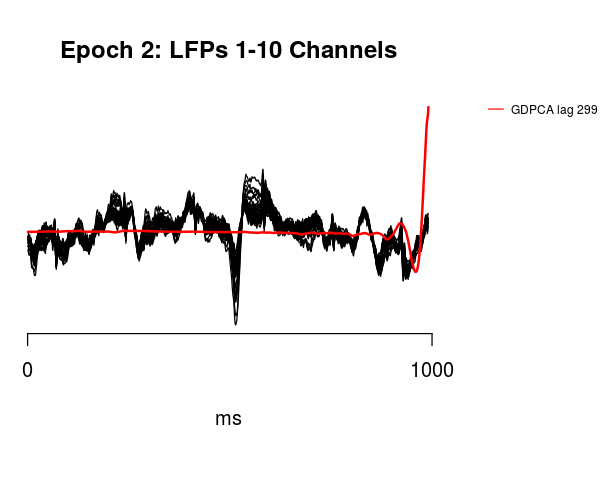

In [18]:
plot_post_lfp_factor(Z_norm, G299, S, 2, legend=c("GDPCA lag 299"), with_spca=FALSE)

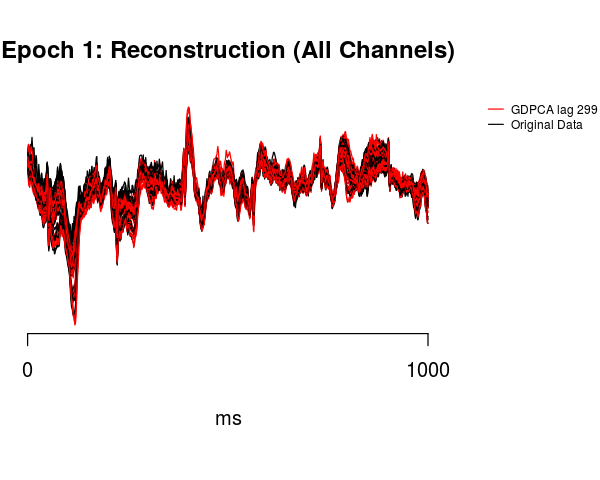

In [19]:
plot_post_lfp_recons(Z_norm, G299, model299, epoch=1, legend=c("GDPCA lag 299", "Original Data"))

In [21]:
epochs = c(1:2)

In [22]:
# Save factors
save_factor_plots(G10, S, epochs, subdir="lag10_factors")
save_factor_plots(G150, S, epochs, subdir="lag150_factors")
save_factor_plots(G299, S, epochs, subdir="lag299_factors")

# Save log periodograms
save_logp_plots(P_g10, P_s, epochs, subdir="lag10_logp")
save_logp_plots(P_g150, P_s, epochs, subdir="lag150_logp")
save_logp_plots(P_g299, P_s, epochs, subdir="lag299_logp")

# Save lfp factors w/out spca
save_lfp_factors(Z_norm, G10, S, epochs, legend=c("GDPCA lag 10"), subdir="lag10_lfp_gfactor")
save_lfp_factors(Z_norm, G150, S, epochs, legend=c("GDPCA lag 150"), subdir="lag150_lfp_gfactor")
save_lfp_factors(Z_norm, G299, S, epochs, legend=c("GDPCA lag 299"), subdir="lag200_lfp_gfactor")

# Save reconstructions
save_grecons(Z_norm, G10, model10, epochs, legend=c("GDPC lag 10", "Original Data"), subdir="lag10_grecon")
save_grecons(Z_norm, G150, model150, epochs, legend=c("GDPC lag 150", "Original Data"), subdir="lag150_grecon")
save_grecons(Z_norm, G299, model299, epochs, legend=c("GDPC lag 299", "Original Data"), subdir="lag299_grecon")